# Categorical Actor-Critic Example

##### Imports

In [1]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

In [2]:
import numpy as np
import torch
from torch import nn, optim
from tqdm import tqdm
from kilroyplot.plot import plt
from kilroyshare.codec import Codec
from kilroytorch.modules.offline import BasicOfflineModule as OfflineModule
from kilroytorch.modules.online import ActorCriticOnlineModule as OnlineModule
from kilroytorch.models.distribution.plain import CategoricalDistributionModel as DistributionModel
from kilroytorch.models.reward.plain import DiscreteRewardModel as RewardModel
from kilroytorch.adapters import PlainDataAdapter as Adapter
from kilroytorch.generators import PlainGenerator as Generator
from kilroytorch.samplers.categorical import ProportionalCategoricalSampler as Sampler
from kilroytorch.losses.distribution import NegativeLogLikelihoodLoss as Loss

##### Helpers

In [3]:
def class_bins(n_classes):
    return np.arange(-0.5, n_classes+0.5)
    
def chunks(data, size):
    for i in range(0, len(data), size):
        yield data[i:i + size]

def generate(generator, model, codec, n):
    return [codec.encode(sample) for sample in generator.generate(model, n)[0]]

def proportional_density(support, f):
    values = np.array([f(x) for x in support])
    weights = values - values.min()
    return weights / weights.sum() if weights.sum() > 0 else np.ones(len(weights)) / len(weights)

## Task

Let's assume the values of the score function for all classes are like shown below.

In [4]:
n_classes = 300

In [5]:
score = lambda value: np.sin(6 * np.pi * value / (n_classes-1)) + np.random.randn() * 0.1  # sine plus some noise

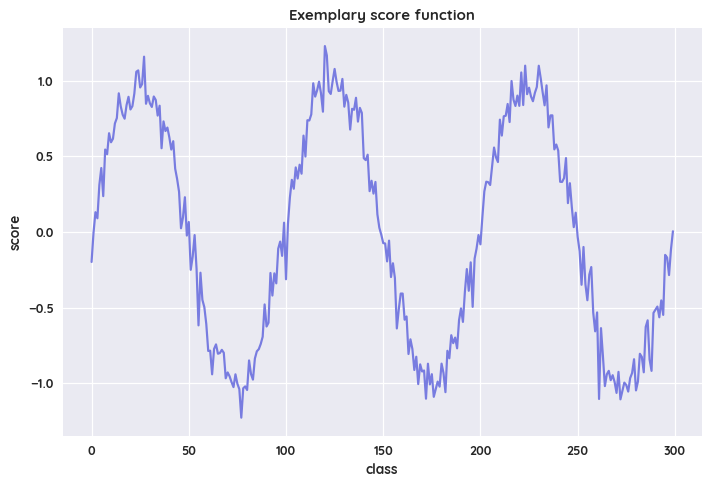

In [6]:
plt.plot(range(n_classes), [score(c) for c in range(n_classes)])
plt.title("Exemplary score function")
plt.xlabel("class")
plt.ylabel("score")
plt.tight_layout()

## Model

In [7]:
class DummyCodec(Codec):
    def encode(self, value):
        return value.item()

    def decode(self, value):
        return torch.tensor(value)

In [8]:
actor = DistributionModel(n_classes)
critic = RewardModel(n_classes)
codec = DummyCodec()
adapter = Adapter()
generator = Generator(Sampler())
offline_module = OfflineModule(
    actor, 
    adapter,
    codec, 
    optim.Adam(actor.parameters(), lr=0.05),
    Loss()
)
online_module = OnlineModule(
    actor, 
    critic,
    generator,
    adapter,
    codec, 
    (optim.Adam(actor.parameters(), lr=0.05), optim.Adam(critic.parameters(), lr=0.1))
)

## Offline

Let's assume real samples are distributed proportional to their relative scores.

In [9]:
probs = proportional_density(range(n_classes), score)
n_samples = 1000
samples = np.random.choice(n_classes, n_samples, p=probs)

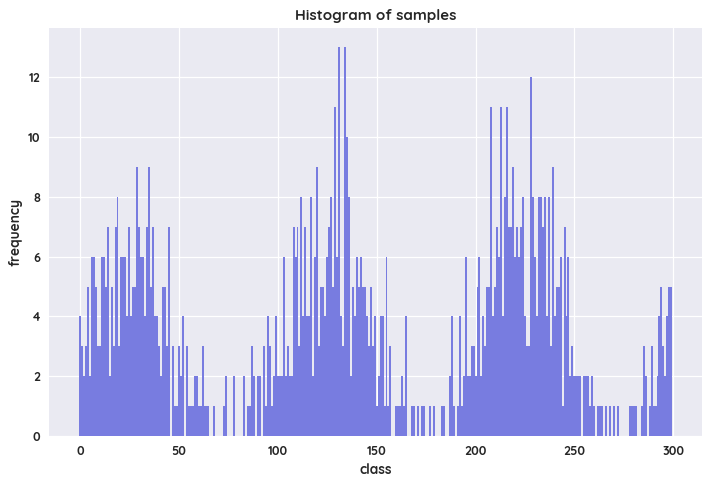

In [10]:
plt.hist(samples, bins=class_bins(n_classes))
plt.title("Histogram of samples")
plt.xlabel("class")
plt.ylabel("frequency")
plt.tight_layout()

In [11]:
n_epochs = 100
batch_size = 512
losses = []

for _ in tqdm(range(n_epochs)):
    epoch_losses = []
    for batch in chunks(samples, batch_size):
        metrics = offline_module.fit(batch)
        epoch_losses.append(metrics["loss"])
        offline_module = offline_module.step()
    losses.append(np.mean(epoch_losses))

100%|██████████| 100/100 [00:00<00:00, 148.27it/s]


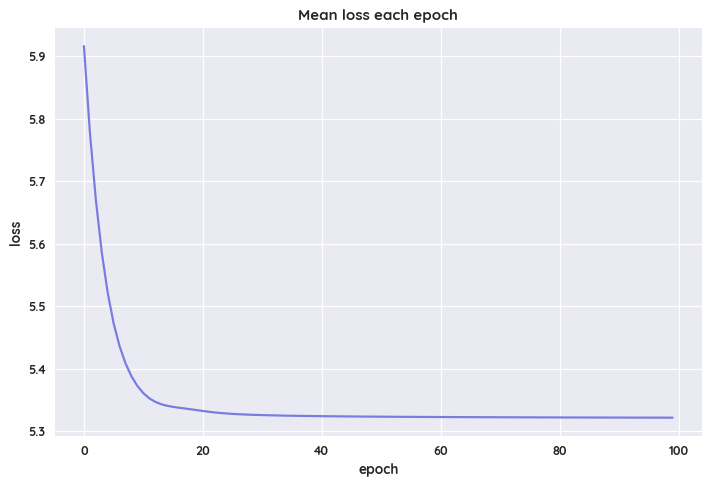

In [12]:
plt.plot(losses)
plt.title("Mean loss each epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.tight_layout()

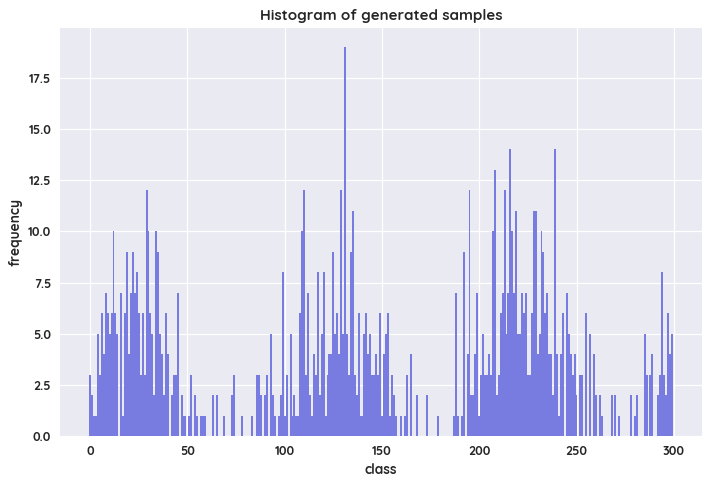

In [13]:
plt.hist(generate(generator, actor, codec, 1000), bins=class_bins(n_classes))
plt.title("Histogram of generated samples")
plt.xlabel("class")
plt.ylabel("frequency")
plt.tight_layout()

## Online

In [14]:
n_iters = 100
iter_size = 512
critic_losses = []
actor_losses = []
mean_scores = []

for _ in tqdm(range(n_iters)):
    scores = {
        key: score(value) for key, value in online_module.sample(iter_size)
    }
    mean_scores.append(np.mean(list(scores.values())))
    metrics = online_module.fit(scores)
    critic_losses.append(metrics["critic_loss"])
    actor_losses.append(metrics["actor_loss"])
    online_module = online_module.step()

100%|██████████| 100/100 [00:08<00:00, 11.59it/s]


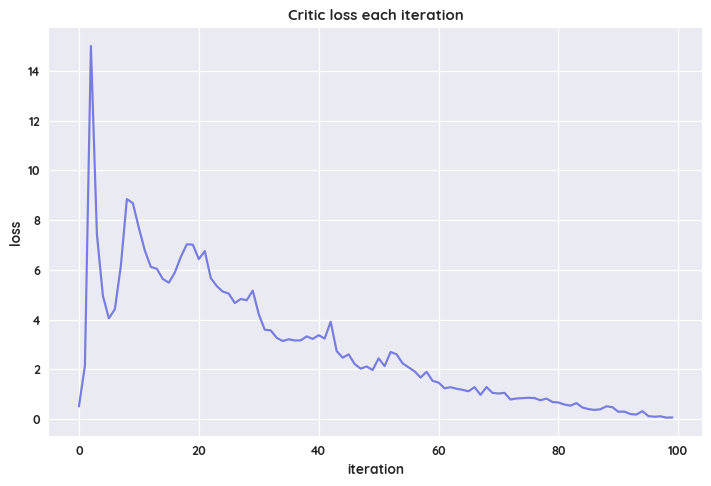

In [15]:
plt.plot(critic_losses)
plt.title("Critic loss each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.tight_layout()

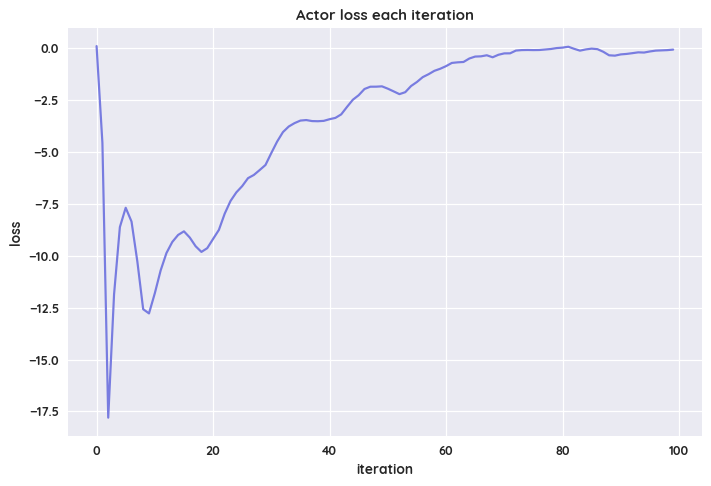

In [16]:
plt.plot(actor_losses)
plt.title("Actor loss each iteration")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.tight_layout()

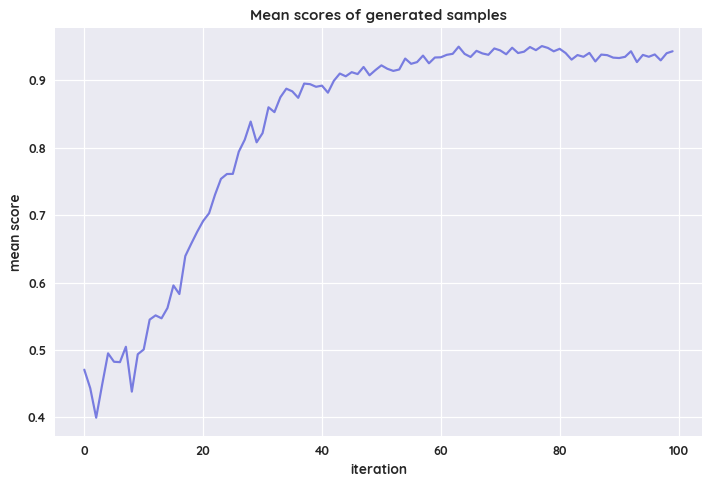

In [17]:
plt.plot(mean_scores)
plt.title("Mean scores of generated samples")
plt.xlabel("iteration")
plt.ylabel("mean score")
plt.tight_layout()

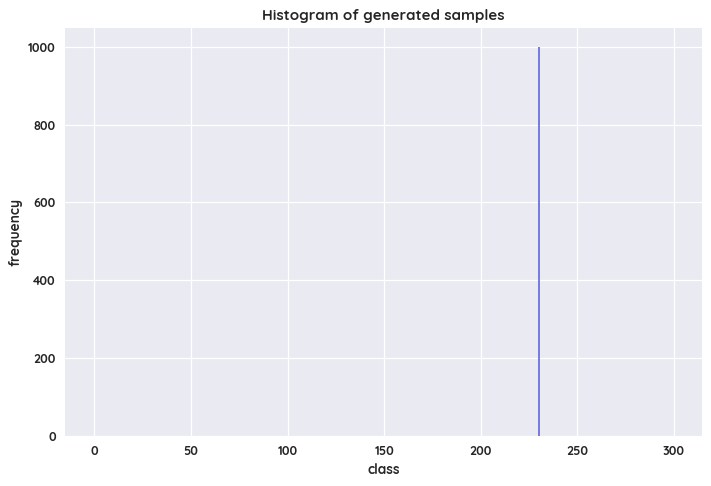

In [18]:
plt.hist(generate(generator, actor, codec, 1000), bins=class_bins(n_classes))
plt.title("Histogram of generated samples")
plt.xlabel("class")
plt.ylabel("frequency")
plt.tight_layout()

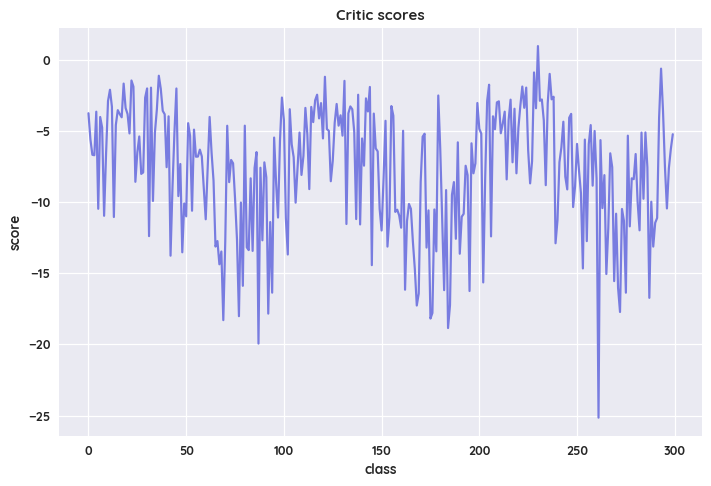

In [19]:
plt.plot(range(n_classes), critic(torch.arange(n_classes).view(-1, 1)).detach().flatten().numpy())
plt.title("Critic scores")
plt.xlabel("class")
plt.ylabel("score")
plt.tight_layout()